# Automate Retraining of Models using SageMaker Pipelines and Lambda

# Learning Objectives
1. Construct a [SageMaker Pipeline](https://aws.amazon.com/sagemaker/pipelines/) that consists of a data preprocessing step and a model training step.
2. Execute a SageMaker Pipeline manually
3. Build infrastructure, using [CloudFormation](https://aws.amazon.com/cloudformation/) and [AWS Lambda](https://aws.amazon.com/lambda/) to allow the Pipeline steps be executed in an event-driven manner when new data is dropped in S3.


## Introduction
This workshop shows how you can build and deploy SageMaker Pipelines for multistep processes. In this example, we will build a pipeline that:

     1. Deduplicates the underlying data
     
     2. Trains a built-in SageMaker algorithm (XGBoost) 

A common workflow is that models need to be retrained when new data arrives. This notebook also shows how you can set up a Lambda function that will retrigger the retraining pipeline when new data comes in.

Please use the `Python 3 (Data Science)` kernel for this workshop.

In [ ]:
import boto3
import json
import logging
import os
import pandas
import sagemaker
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.steps import ProcessingStep, TrainingStep
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.inputs import TrainingInput
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.estimator import Estimator
from time import gmtime, strftime

# set logs if not done already
logger = logging.getLogger("log")
if not logger.handlers:
    logger.setLevel(logging.INFO)
    logger.addHandler(logging.StreamHandler())

First, get permissions and other information. We will also create a pipeline name

In [ ]:
session = sagemaker.Session()
default_bucket = session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
s3_client = boto3.client("s3", region_name=region)

current_timestamp = strftime("%m-%d-%H-%M", gmtime())
pipeline_name = f"my-pipeline-{current_timestamp}"
prefix = f"pipeline-lab{current_timestamp}"

## Transfer Data into Your Account

In [ ]:
copy_source = {
    "Bucket": "aws-hcls-ml",
    "Key": "workshop/immersion_day_workshop_data_DO_NOT_DELETE/data/ObesityDataSet_with_duplicates.csv",
}
s3_client.copy(
    copy_source, default_bucket, f"{prefix}/ObesityDataSet_with_duplicates.csv"
)

copy_source = {
    "Bucket": "aws-hcls-ml",
    "Key": "workshop/immersion_day_workshop_data_DO_NOT_DELETE/kick_off_sagemaker_pipelines_lambda/other_material/lambda.zip",
}
s3_client.copy(copy_source, default_bucket, f"{prefix}/lambda.zip")

## Define the Pipeline

First we will create a preprocessing step. The preprocessing step simply removes duplicated rows from the dataset. The `preprocessing.py` script will be written locally, and then built as a SageMaker Pipelines step.

In [ ]:
input_data = ParameterString(
    name="InputData",
    default_value=f"s3://{default_bucket}/{prefix}/ObesityDataSet_with_duplicates.csv",
)

In [ ]:
%%writefile preprocessing.py
import pandas
import os
base_dir = "/opt/ml/processing/input"
the_files = os.listdir(base_dir)
the_file=[i for i in the_files if ".csv" in i][0] #get the first csv
print(the_file)
df_1=pandas.read_csv(f'{base_dir}/{the_file}',engine='python')
df_2=df_1.drop_duplicates()
df_2.to_csv(f'/opt/ml/processing/output/deduped_{the_file}.csv')               


In [ ]:
# Specify the container and framework options

sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    instance_type="ml.t3.medium",
    instance_count=1,
    base_job_name="sklearn-abalone-process",
    role=role,
)

Now will will turn the preprocessing step as a SageMaker Processing Step with SageMaker Pipelines.

In [ ]:
step_process = ProcessingStep(
    name="deduplication-process",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="deduplicated", source="/opt/ml/processing/output")
    ],
    code="preprocessing.py",
)

## Define the Model
Now we will create a SageMaker model. We will use the SageMaker built-in XGBoost Algorithm.

In [ ]:
# Define the model training parameters
model_path = f"s3://{default_bucket}/{prefix}/myPipelineTrain"

image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type="ml.m5.large",
)
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type="ml.m5.large",
    instance_count=1,
    output_path=model_path,
    role=role,
)
xgb_train.set_hyperparameters(
    objective="reg:linear",
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    silent=0,
)

Turn the model training into a SageMaker Pipeline Training Step.

In [ ]:
# Define the training steps

step_train = TrainingStep(
    name="model-training",
    estimator=xgb_train,
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "deduplicated"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "deduplicated"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    },
)

## Create and Start the Pipeline

In [ ]:
# Create a two-step data processing and model training pipeline

pipeline_name = "ObesityModelRetrainingPipeLine"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        input_data,
    ],
    steps=[step_process, step_train],
)
pipeline.upsert(role_arn=role)
pipeline_execution = pipeline.start()

In [ ]:
# Wait 15 minutes for the pipeline to finish running. In the meantime, you can monitor its progress in SageMaker Studio
pipeline_execution.wait()

## Deploy a CloudFormation Template to retrain the Pipeline

Now we will deploy a cloudformation template that will allow for automated calling of the Pipeline when new files are dropped in an S3 bucket.

The architecture looks like this:

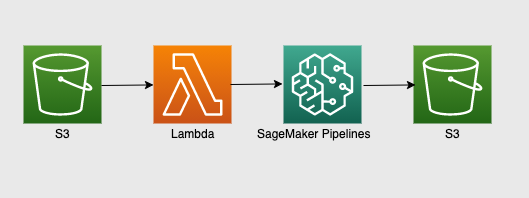

NOTE: In order to run the following steps you must first associate the following IAM policies to your SageMaker execution role:
- cloudformation:CreateStack
- cloudformation:DeleteStack
- cloudformation:DescribeStacks
- iam:CreateRole
- iam:DeleteRole
- iam:DeleteRolePolicy
- iam:GetRole
- iam:GetRolePolicy
- iam:PassRole
- iam:PutRolePolicy
- lambda:AddPermission
- lambda:CreateFunction
- lambda:GetFunction
- lambda:DeleteFuncton

In [ ]:
# Create a new CloudFormation stack to trigger retraining with new data

stack_name = "sagemaker-automated-retraining"

with open("cfn_sagemaker_pipelines.yaml") as f:
    template_str = f.read()
cfn = boto3.client("cloudformation")
cfn.create_stack(
    StackName=stack_name,
    TemplateBody=template_str,
    Capabilities=["CAPABILITY_IAM"],
    Parameters=[
        {"ParameterKey": "StaticCodeBucket", "ParameterValue": default_bucket},
        {"ParameterKey": "StaticCodeKey", "ParameterValue": f"{prefix}/lambda.zip"},
    ],
)

In [ ]:
# Wait until stack creation is complete
waiter = cfn.get_waiter("stack_create_complete")
waiter.wait(StackName=stack_name)

In [ ]:
# Identify the S3 bucket for triggering the training pipeline
input_bucket_name = cfn.describe_stacks(StackName=stack_name)["Stacks"][0]["Outputs"][0]["OutputValue"]

In [ ]:
# Copy the training data to the input bucket to start a new pipeline execution
copy_source = {
    "Bucket": default_bucket,
    "Key": f"{prefix}/ObesityDataSet_with_duplicates.csv",
}
s3_client.copy(copy_source, input_bucket_name, "ObesityDataSet_with_duplicates.csv")

### (Optional)

1. Inspect that the `InputBucket` has new data
2. Examine the `SageMaker Pipelines` execution from the SageMaker Studio console

In [ ]:
#!aws s3 rm --recursive s3://{input_bucket_name}

## Closing

In this notebook we demonstrated how to create a SageMaker pipeline for data processing and model training and triggered it using an S3 event.